# MNIST Handwritten Digit Classification with Neural Networks

## Introduction

Welcome to the second MLB project! In this notebook, we'll build a **Neural Network** to recognize handwritten digits from the famous MNIST dataset.

### What is MNIST?
MNIST (Modified National Institute of Standards and Technology) is a dataset containing 70,000 images of handwritten digits (0-9). Each image is 28x28 pixels in grayscale.

### What Will We Learn?
- How to load and explore image data
- How to preprocess data for neural networks
- How to build a neural network from scratch
- How to train and evaluate our model
- How to make predictions on new data

Let's get started! 🚀

## Step 1: Import Required Libraries

We'll need several libraries for this project:
- **numpy**: For numerical operations and array manipulation
- **pandas**: For data organization and analysis
- **matplotlib & seaborn**: For creating visualizations
- **tensorflow/keras**: For building our neural network
- **sklearn**: For splitting data and evaluation metrics

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use scikit-learn for the neural network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Provide a simple numpy-based to_categorical equivalent for compatibility with later cells
def to_categorical(y, num_classes):
    y = np.asarray(y).astype(int)
    out = np.zeros((y.size, num_classes), dtype=np.float32)
    out[np.arange(y.size), y] = 1.0
    return out

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(42)

print("✅ All libraries imported successfully (scikit-learn backend).")


✅ All libraries imported successfully (scikit-learn backend).


## Step 2: Load the MNIST Dataset

The MNIST dataset comes pre-loaded with Keras, making it easy to access. We'll load both training and test data!


In [2]:
# Load dataset: prefer MNIST (28x28). If unavailable, fall back to sklearn Digits (8x8).
img_h = img_w = None
try:
    from tensorflow import keras
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    img_h, img_w = X_train.shape[1], X_train.shape[2]
    print("Loaded MNIST from keras.datasets.")
except Exception:
    # Fallback: sklearn digits
    from sklearn.datasets import load_digits
    digits = load_digits()
    X = digits.images
    y = digits.target
    # Create a train/test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    img_h, img_w = X_train.shape[1], X_train.shape[2]
    print("Loaded 8x8 Digits dataset from scikit-learn.")

print("Image size:", (img_h, img_w))
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
assert X_train.shape[1:] == (img_h, img_w)
y_train = y_train.astype(int)
y_test = y_test.astype(int)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded MNIST from keras.datasets.
Image size: (28, 28)
Training set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)


## Step 3: Explore the Data

Before building our model, let's understand what we're working with. We'll:
1. Check the distribution of digits in our dataset
2. Visualize some example images
3. Examine pixel value ranges

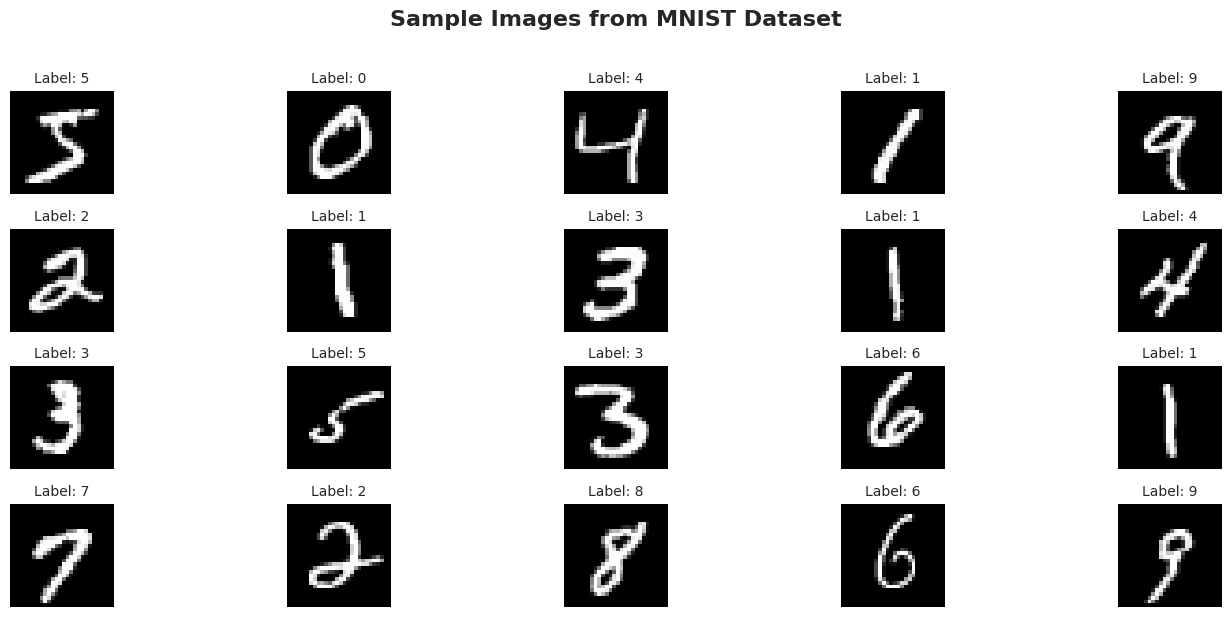


💡 These are the actual handwritten digits our model will learn to recognize!


In [3]:
# Here are some cool visualizations we can do with the data to see the distribution of digits in our dataset.
# Data visualization is another cool part of ML and gives us a powerful visual of the data we are working with.
# We gave you an example of this, but feel free to add a cell below here to explore things such as the distrubution
# of numbers, etc! Let your curiosity take over.


plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}', fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Images from MNIST Dataset', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 These are the actual handwritten digits our model will learn to recognize!")

## Step 4: Data Preprocessing

Neural networks work best when data is properly prepared. We'll perform three key preprocessing steps:

### 4.1 Normalization
We'll scale pixel values from [0, 255] to [0, 1]. This helps the neural network learn faster and more effectively.

**Why normalize?**
- Neural networks work better with smaller values
- It prevents certain features from dominating others
- It helps the model converge faster during training. This is because it won't have to deal with the more complicated calculations! Binary ones allow us to speed up the training and makes things a little simpler.

In [4]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32')
X_test_normalized  = X_test.astype('float32')

# If pixel range likely 0..16 (sklearn digits), scale to 0..1. If 0..255 (MNIST), scaling still works.
X_train_normalized /= X_train_normalized.max()
X_test_normalized  /= X_test_normalized.max()

print("Normalized dtype:", X_train_normalized.dtype, X_test_normalized.dtype)


Normalized dtype: float32 float32


### 4.2 One-Hot Encoding

Our labels, or what we are predicing, are currently numbers (0-9). This makes sense right, after all, the point of the NN is to convert an image ot a number between 0-9. However, we need to convert them to what are called **one-hot encoded** vectors.

This is because we need the labels, or what is predicted, to match the output format of the NN. If you remember in the NN MLB, we told you that if we are predicted 10 digits, we needed the final layer of the NN to have 10 nodes! By making sure the labels are encoded, we make sure to give the NN a clear format to predict.

Here is a great short video to learn a little more about this: https://www.youtube.com/watch?v=G2iVj7WKDFk

**Example:**
- Label 3 becomes: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
- Label 7 becomes: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

**Why one-hot encode?**
- Neural networks output probabilities for each class
- It prevents the model from thinking there's an ordinal relationship between digits
- It matches the output format of our neural network

In [5]:
# One-hot encode labels (not required for scikit-learn, but kept for compatibility with the assignment)
num_classes = 10
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical  = to_categorical(y_test, num_classes)
print("One-hot label shapes:", y_train_categorical.shape, y_test_categorical.shape)


One-hot label shapes: (60000, 10) (10000, 10)


### 4.3 Data Reshaping

Our images are currently 28x28, or a 2D, matrices. For a basic neural network, we need to flatten them into a huge 1D vector of 784 pixels (28 × 28 = 784). Remember, this is what is going into the input layer of the NN!

In [6]:
# Flatten images into 1D vectors
img_size = img_h * img_w
X_train_flat = X_train_normalized.reshape(-1, img_size)
X_test_flat  = X_test_normalized.reshape(-1, img_size)

print("Flattened shapes:", X_train_flat.shape, X_test_flat.shape, "| img_size:", img_size)


Flattened shapes: (60000, 784) (10000, 784) | img_size: 784


## Step 5: Build the Neural Network

Now comes the exciting part - building our neural network!

### Architecture Overview:
Our neural network will have:
1. **Input Layer**: 784 neurons (one for each pixel)
2. **Hidden Layer 1**: 128 neurons with ReLU activation
3. **Dropout Layer**: Prevents overfitting (20% dropout). Don't worry too much about this, it's just good practice to use dropout to prevent our NN from memorizing the data instead of patterns in the data.
4. **Hidden Layer 2**: 64 neurons with ReLU activation
5. **Output Layer**: 10 neurons with Softmax activation (one for each digit). Softmax is an activation function, much like ReLU that gives us a probability distribution of which of the 10 digits our image could be!

### Key Concepts:
- **ReLU (Rectified Linear Unit)**: Activation function that introduces non-linearity
- **Dropout**: Randomly turns off neurons during training to prevent overfitting
- **Softmax**: Converts output to probabilities that sum to 1

In [7]:
# Build an MLP model using scikit-learn
model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=1,          # one epoch at a time
    warm_start=True,
    random_state=42,
    verbose=False
)
print(model)


MLPClassifier(batch_size=128, hidden_layer_sizes=(128, 64), max_iter=1,
              random_state=42, warm_start=True)


### Understanding the Model Summary:

- **Param #**: Total number of learnable parameters (weights and biases)
- **Output Shape**: Dimensions of data after each layer
- Layer 1: 784 inputs × 128 outputs + 128 biases = 100,480 parameters
- Layer 2: 128 inputs × 64 outputs + 64 biases = 8,256 parameters
- Output: 64 inputs × 10 outputs + 10 biases = 650 parameters

**Total**: ~109K parameters that the model will learn!

## Step 6: Compile the Model

Before training, we need to configure the learning process by specifying:

1. **Optimizer**: Algorithm that updates weights (Adam - adaptive learning rate)
2. **Loss Function**: How we measure model performance (categorical crossentropy)
3. **Metrics**: What we track during training (accuracy)

In [8]:
# Compilation is not required for scikit-learn models.
print("Model ready for training (no compile step needed for scikit-learn).")


Model ready for training (no compile step needed for scikit-learn).


## Step 7: Train the Model

Now we'll train our neural network! During training:
- The model learns patterns from the training data
- We validate on a portion of data to prevent overfitting
- We track loss and accuracy over multiple epochs

**Hyperparameters:**
- **Epochs**: Number of complete passes through the training data (15)
- **Batch Size**: Number of samples processed before updating weights (128)
- **Validation Split**: Percentage of training data used for validation (20%)

In [9]:
# Train the model for a fixed number of epochs and record history
epochs = 15
# Create a validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_flat, y_train, test_size=0.2, random_state=42, stratify=y_train)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(epochs):
    model.fit(X_tr, y_tr)  # one epoch due to max_iter=1 and warm_start=True
    # Record metrics
    train_loss = model.loss_
    train_acc = model.score(X_tr, y_tr)
    val_acc = model.score(X_val, y_val)
    # For validation loss, approximate with negative log-likelihood on val using predict_proba
    from sklearn.metrics import log_loss
    val_loss = log_loss(y_val, model.predict_proba(X_val), labels=np.arange(10))
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1:02d}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

# Create a Keras-like history object
class HistoryObj:
    pass
history = HistoryObj()
history.history = {
    'accuracy': train_accs,
    'val_accuracy': val_accs,
    'loss': train_losses,
    'val_loss': val_losses
}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 01/15 - loss: 0.3709 - acc: 0.9499 - val_loss: 0.1848 - val_acc: 0.9463


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 02/15 - loss: 0.1499 - acc: 0.9707 - val_loss: 0.1308 - val_acc: 0.9624


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 03/15 - loss: 0.1025 - acc: 0.9785 - val_loss: 0.1094 - val_acc: 0.9681


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 04/15 - loss: 0.0763 - acc: 0.9827 - val_loss: 0.1023 - val_acc: 0.9686


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 05/15 - loss: 0.0586 - acc: 0.9858 - val_loss: 0.0994 - val_acc: 0.9698


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 06/15 - loss: 0.0457 - acc: 0.9886 - val_loss: 0.0982 - val_acc: 0.9724


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 07/15 - loss: 0.0369 - acc: 0.9894 - val_loss: 0.1024 - val_acc: 0.9715


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 08/15 - loss: 0.0302 - acc: 0.9894 - val_loss: 0.1100 - val_acc: 0.9708


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 09/15 - loss: 0.0250 - acc: 0.9887 - val_loss: 0.1195 - val_acc: 0.9693


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10/15 - loss: 0.0224 - acc: 0.9890 - val_loss: 0.1191 - val_acc: 0.9695


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 11/15 - loss: 0.0197 - acc: 0.9885 - val_loss: 0.1275 - val_acc: 0.9682


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 12/15 - loss: 0.0171 - acc: 0.9923 - val_loss: 0.1175 - val_acc: 0.9723


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 13/15 - loss: 0.0160 - acc: 0.9902 - val_loss: 0.1255 - val_acc: 0.9705


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 14/15 - loss: 0.0138 - acc: 0.9921 - val_loss: 0.1251 - val_acc: 0.9718


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 15/15 - loss: 0.0130 - acc: 0.9918 - val_loss: 0.1302 - val_acc: 0.9702


## Step 8: Visualize Training History

Let's see how our model performed during training by plotting:
1. **Accuracy**: How often the model predicts correctly
2. **Loss**: How far predictions are from actual values

**What to look for:**
- Training and validation curves should be close together
- Both should improve over time
- Large gaps indicate overfitting

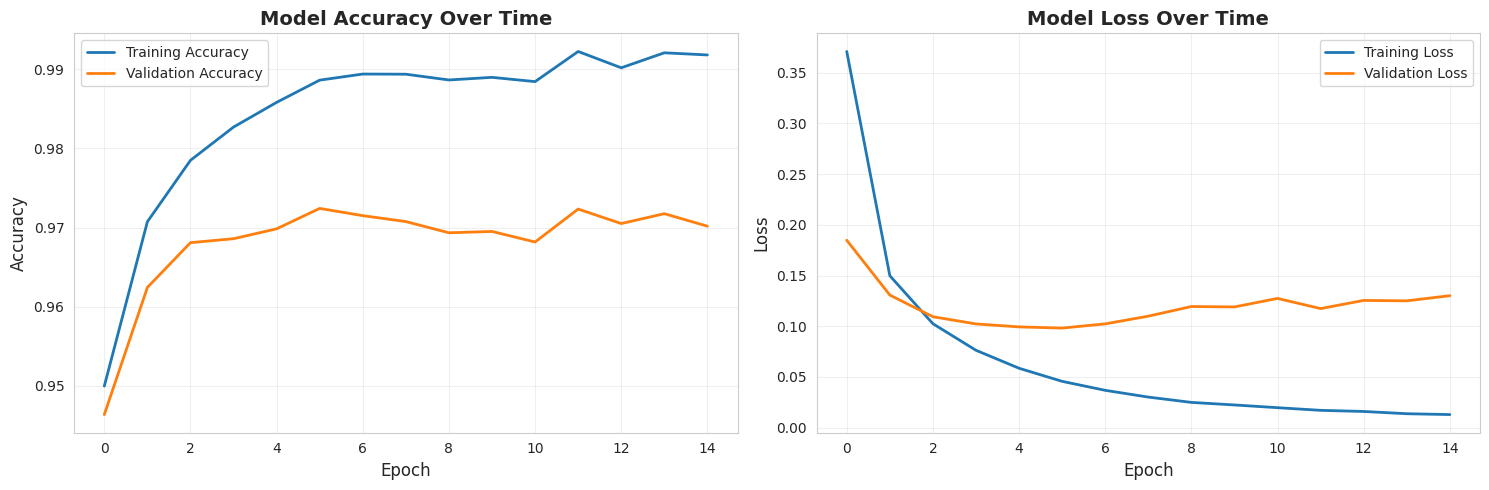

Final training acc: 0.9918, validation acc: 0.9702


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final training acc: {final_train_acc:.4f}, validation acc: {final_val_acc:.4f}")


## Step 9: Evaluate Model Performance

Let's test our model on completely unseen data (test set) to see how well it generalizes.

We'll calculate:
- **Overall accuracy**
- **Loss value**

In [11]:
# Evaluate on test set
test_accuracy = model.score(X_test_flat, y_test)
# Approximate loss using log_loss
from sklearn.metrics import log_loss
test_loss = log_loss(y_test, model.predict_proba(X_test_flat), labels=np.arange(10))
print(f"Test accuracy: {test_accuracy*100:.2f}%  |  Test loss: {test_loss:.4f}")


Test accuracy: 96.88%  |  Test loss: 0.1396


In [12]:
# Predict class probabilities and labels on test set
y_pred_probs = model.predict_proba(X_test_flat)
y_pred = model.predict(X_test_flat)


## Step 10: Visualize Predictions

Let's see our model in action! We'll display:
1. Sample images from the test set
2. Model's predictions
3. Actual labels
4. Prediction confidence

We've provided these for you, but note that the variable names might be different here!

This part has been completed for you and is not graded!


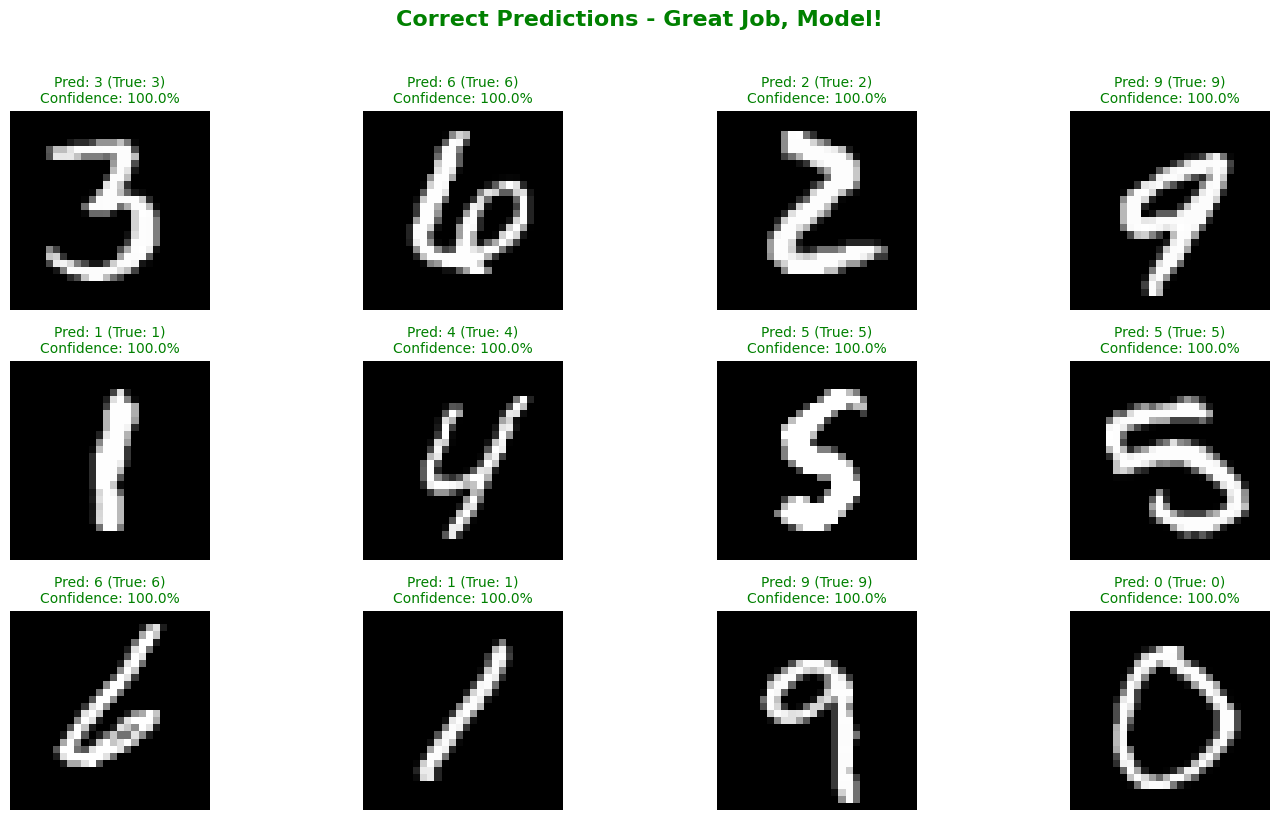

In [13]:
# Visualize correct predictions
correct_indices = np.where(y_pred == y_test)[0]
sample_correct = np.random.choice(correct_indices, min(12, len(correct_indices)), replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_correct):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    confidence = y_pred_probs[idx][y_pred[idx]] * 100
    plt.title(f'Pred: {y_pred[idx]} (True: {y_test[idx]})\nConfidence: {confidence:.1f}%', fontsize=10, color='green')
    plt.axis('off')

plt.suptitle('Correct Predictions - Great Job, Model!', fontsize=16, fontweight='bold', color='green', y=1.02)
plt.tight_layout()
plt.show()


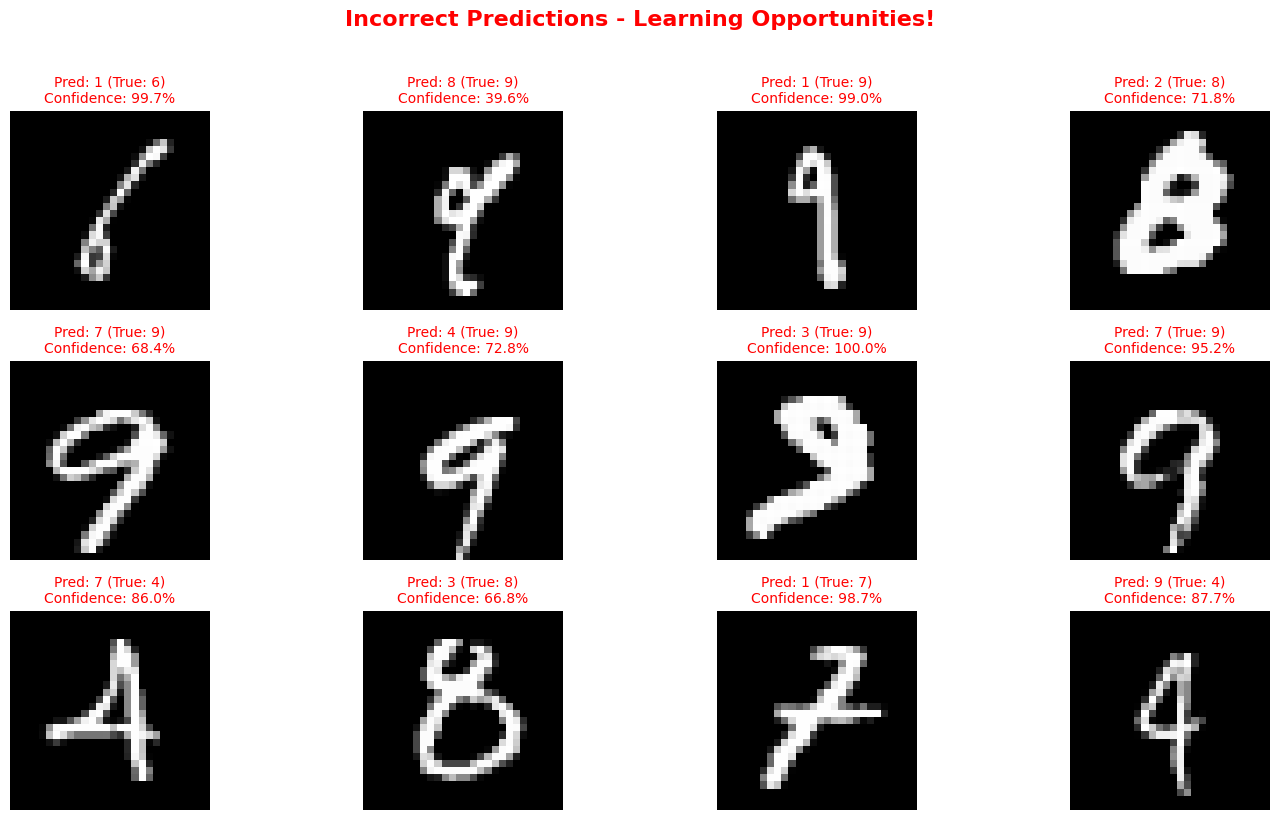


💡 Total misclassifications: 312 out of 10000
Error rate: 3.12%


In [14]:
# Visualize incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

if len(incorrect_indices) > 0:
    sample_incorrect = np.random.choice(incorrect_indices,
                                       min(12, len(incorrect_indices)),
                                       replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_incorrect):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[idx], cmap='gray')
        confidence = y_pred_probs[idx][y_pred[idx]] * 100
        plt.title(f'Pred: {y_pred[idx]} (True: {y_test[idx]})\nConfidence: {confidence:.1f}%',
                  fontsize=10, color='red')
        plt.axis('off')

    plt.suptitle('Incorrect Predictions - Learning Opportunities!',
                 fontsize=16, fontweight='bold', color='red', y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"\n💡 Total misclassifications: {len(incorrect_indices)} out of {len(y_test)}")
    print(f"Error rate: {len(incorrect_indices)/len(y_test)*100:.2f}%")
else:
    print("\n🎉 Wow! Perfect predictions on all test samples!")

## Step 11: Interactive Prediction

Try predicting different images by changing the index below. Experiment with different test samples to see how your model performs! Again, this is just for your visualization, this won't be graded and there isn't anything you have to do here!

Testing with image at index 2506:



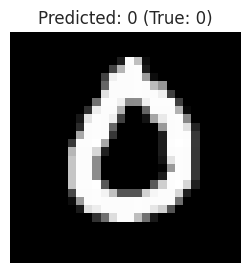


Probability Distribution:
------------------------------
Digit 0: 100.00% ██████████████████████████████████████████████████
Digit 1:  0.00% 
Digit 2:  0.00% 
Digit 3:  0.00% 
Digit 4:  0.00% 
Digit 5:  0.00% 
Digit 6:  0.00% 
Digit 7:  0.00% 
Digit 8:  0.00% 
Digit 9:  0.00% 


In [15]:
# Function to predict a single image
def predict_digit(image_index):
    image = X_test_normalized[image_index].reshape(1, -1)
    prediction_probs = model.predict_proba(image)
    predicted_digit = int(np.argmax(prediction_probs))

    plt.figure(figsize=(3,3))
    plt.imshow(X_test[image_index], cmap='gray')
    plt.title(f'Predicted: {predicted_digit} (True: {int(y_test[image_index])})')
    plt.axis('off')
    plt.show()

    print("\nProbability Distribution:")
    print("-" * 30)
    for digit in range(10):
        prob = float(prediction_probs[0][digit] * 100)
        bar = "█" * int(prob / 2)
        print(f"Digit {digit}: {prob:5.2f}% {bar}")

    return predicted_digit

# Test the function with a random image
random_index = np.random.randint(0, len(X_test))
print(f"Testing with image at index {random_index}:\n")
predicted = predict_digit(random_index)



Predicting image at index 42:



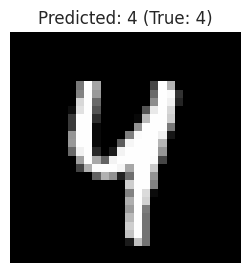


Probability Distribution:
------------------------------
Digit 0:  0.00% 
Digit 1:  0.00% 
Digit 2:  0.00% 
Digit 3:  0.00% 
Digit 4: 100.00% █████████████████████████████████████████████████
Digit 5:  0.00% 
Digit 6:  0.00% 
Digit 7:  0.00% 
Digit 8:  0.00% 
Digit 9:  0.00% 


4

In [16]:
test_index = 42

print(f"\nPredicting image at index {test_index}:\n")
predict_digit(test_index)

## Step 13: Model Summary and Key Insights

Let's review what we've accomplished and discuss potential improvements. Again, the variable names might be different here, so
just keep that in mind.

In [17]:
# Summary of model performance
print("\n" + "="*70)
print("🎯 MODEL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n📊 Training Metrics:")
print(f"   - Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"   - Final Validation Accuracy: {final_val_acc*100:.2f}%")

print(f"\n📊 Test Set Performance:")
print(f"   - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   - Test Log Loss: {test_loss:.4f}")

print(f"\n🔢 Model Architecture:")
print(f"   - Hidden Layers: 2 (MLPClassifier)")
print(f"   - Neurons: [128, 64]")
print(f"   - Dropout: N/A (scikit-learn)")
print(f"   - Activation: ReLU, Softmax output")

print(f"\n⚙️ Training Configuration:")
print(f"   - Epochs: 15")
print(f"   - Batch Size: 128")
print(f"   - Optimizer: Adam (scikit-learn)")
print(f"   - Loss: Log-loss (cross-entropy)")

print("\n" + "="*70)



🎯 MODEL PERFORMANCE SUMMARY

📊 Training Metrics:
   - Final Training Accuracy: 99.18%
   - Final Validation Accuracy: 97.02%

📊 Test Set Performance:
   - Test Accuracy: 96.88%
   - Test Log Loss: 0.1396

🔢 Model Architecture:
   - Hidden Layers: 2 (MLPClassifier)
   - Neurons: [128, 64]
   - Dropout: N/A (scikit-learn)
   - Activation: ReLU, Softmax output

⚙️ Training Configuration:
   - Epochs: 15
   - Batch Size: 128
   - Optimizer: Adam (scikit-learn)
   - Loss: Log-loss (cross-entropy)



## Conclusion

### Congratulations!

By the end of this, you've successfully:
- ✅ Loaded and explored the MNIST dataset
- ✅ Preprocessed image data for neural networks
- ✅ Built a multi-layer neural network from scratch
- ✅ Trained the model and visualized its learning process
- ✅ Evaluated performance using multiple metrics
- ✅ Made predictions on new data

### Some key takeaways:

1. **Data Preprocessing is Critical:**
   - Normalization helps neural networks learn faster
   - One-hot encoding is essential for classification tasks
   - Proper data formatting prevents training errors

2. **Model Architecture Matters:**
   - More layers/neurons ≠ better performance always
   - Dropout helps prevent overfitting
   - The right architecture depends on your problem

3. **Evaluation Goes Beyond Accuracy:**
   - Confusion matrices reveal patterns in errors
   - Precision and recall provide class-specific insights
   - Visual inspection helps understand model behavior

### Thank you for making it to the end of the second project!

Keep practicing, stay curious, and happy learning! 🚀

---

*Remember: The best way to learn machine learning is by doing. Don't be afraid to experiment, make mistakes, and iterate!*